**KNOWLEDGE REPRESENTATION**

*Knowledge Representation is Powerful tool for extracting information from tools*

# Importing Library

In [0]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 
#use the networkx library to create a network from dataframe
import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

# Importing the data set
Data set is simple bank conversatation between Customer and bank employee.

In [2]:
candidate_sentences = pd.read_csv("data.csv")
candidate_sentences.shape

(1481, 2)

In [3]:
#Sample Dataset
candidate_sentences['sentence'].sample(5)

225                                                                      What is Amortization
790                                                         How do I make my premium payments
510                                          Can TDS be recovered from my principle of the FD
1037                    I don’t want to wait till 60 years for retirement. Is there a way out
547     Can I have a Super saver facility and a Sweep-in facility on the same Savings Account
Name: sentence, dtype: object

# Entites Extraction
The extraction of a single word entity from a sentence is done with the help of parts of speech (POS) tags.
Which Give objects and subjects from Sentence when there is Multiple object and subject are there.

In [4]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... pobj
d823 ... punct


In [0]:
def get_entities(sent):
  
  ent1 = ""
  ent2 = ""

  #prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively.
  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  #prefix and modifier will hold the text that is associated with the subject or the object.
  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):

    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not.if yes we will keep it in the prefix variable.
      # A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      #if the token is the subject, then it will be captured as the first entity in the ent1 variable.
      #Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      # if the token is the object, then it will be captured as the second entity in the ent2 variable.
      #Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      #Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [6]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [7]:
#use function to extract these entity pairs for all the sentences in our data:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 1481/1481 [00:14<00:00, 103.83it/s]


In [8]:
entity_pairs[10:20]

[['address', 'loan account'],
 ['dated  I', 'repayment/ loan'],
 ['I', 'repayment/ loan'],
 ['How  I', 'repayment/ loan'],
 ['How  I', 'loan account'],
 ['much  I', 'Business Loan'],
 ['How  I', 'Business Loan'],
 ['loan tenure options', 'Business Loan'],
 ['I', 'car loan'],
 ['long  tenure', 'loan']]

**Relation / Predicate Extraction**

In [0]:
#The relation is actually the main verb in a sentence.
#function tries to find the ROOT word or the main verb in the sentence.
#Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word.
#If yes, then it is added to the ROOT word.

def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)


In [10]:
get_relation("John completed the task")

'completed'

In [11]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 1481/1481 [00:14<00:00, 104.91it/s]


In [12]:
pd.Series(relations).value_counts()[:50]

is               276
are              165
Is                74
get               59
need              50
obtain            46
Are               44
have              37
take              31
change            24
use               23
open              22
done with         17
make              17
access            17
avail of          14
happens           13
apply for         13
know              13
What              12
be                12
buy               11
do in             11
wish               9
required           9
do                 9
covered under      9
resolve            7
are available      7
carry at           7
repay              7
stop               6
meant by           6
included as        6
renew              6
am unable          6
enquire about      6
contact            6
acquire            6
mean by            5
used               5
accepted as        5
cancel             5
offer              5
contact in         5
include            4
choose             4
cover natural

In [0]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [0]:
# create a directed-graph from a dataframe using networkx
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

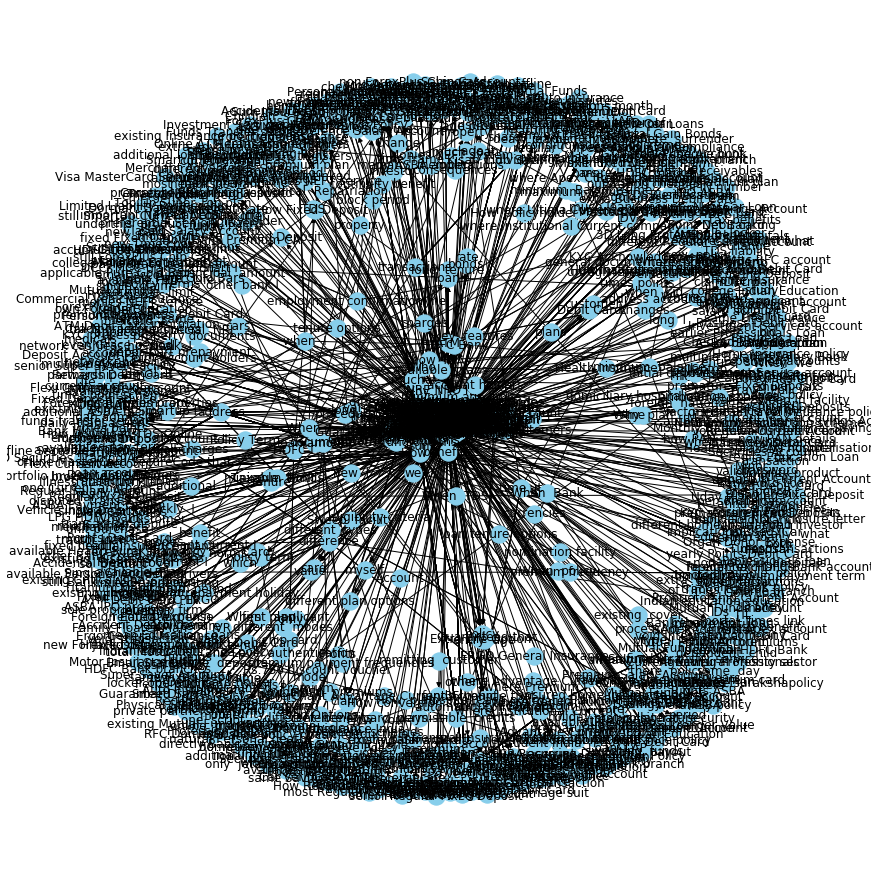

In [15]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

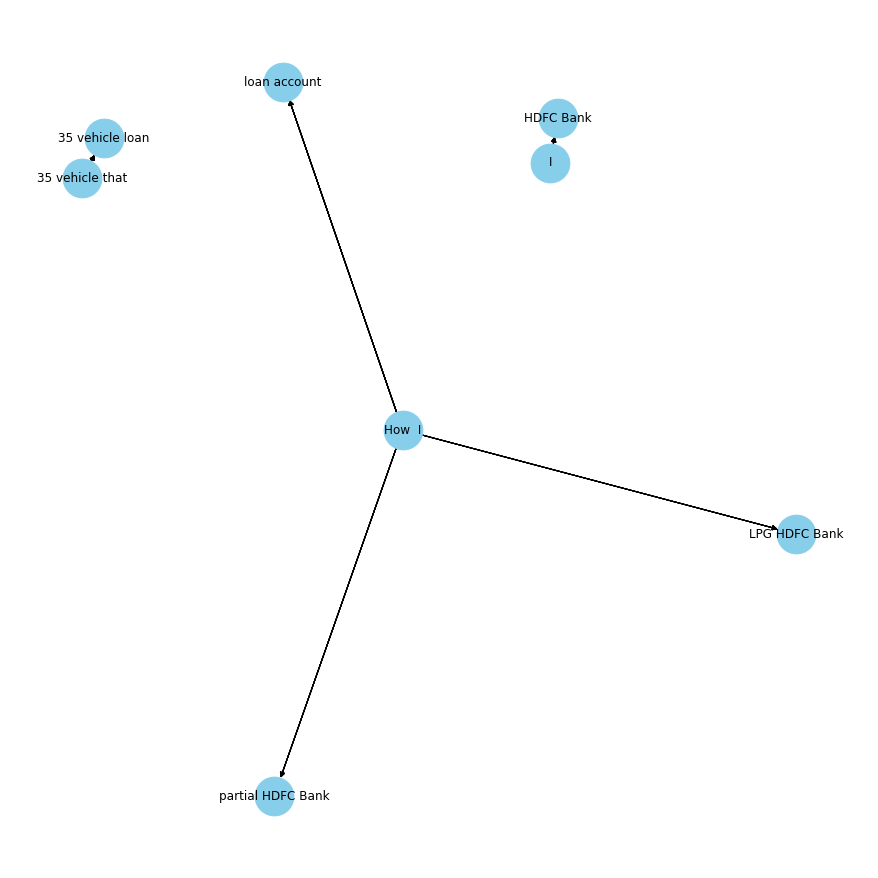

In [16]:
#Finding the relation for specific relation element
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="obtain"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

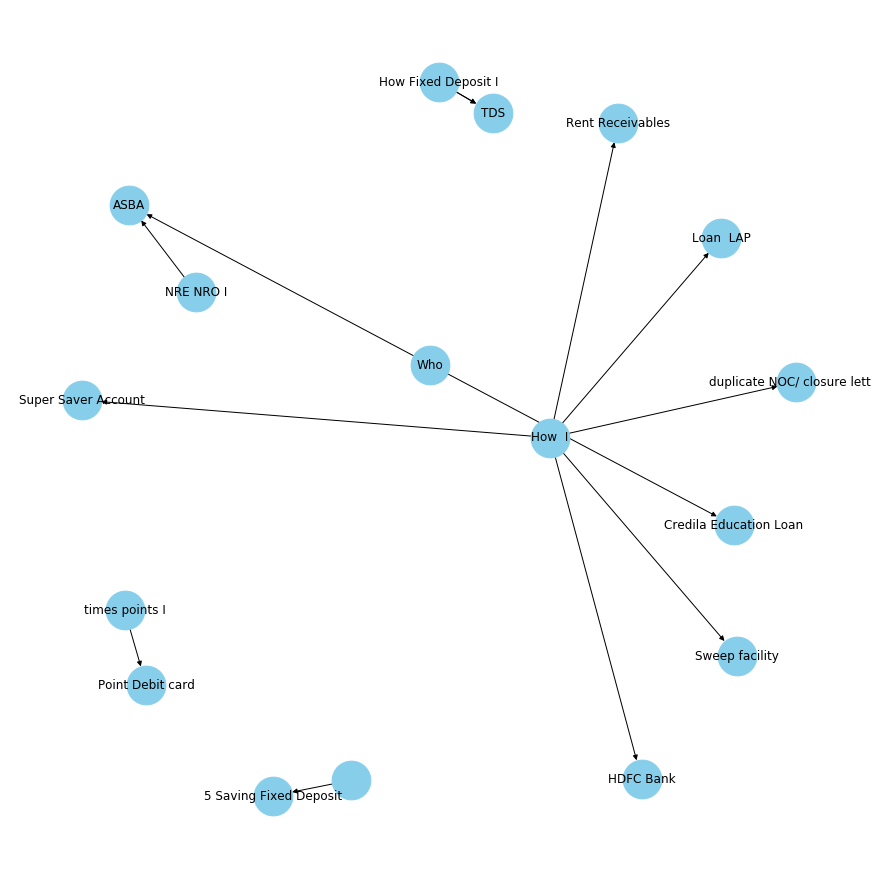

In [17]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="apply for"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()